In [1]:
import pandas as pd
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt
from TomTomUnifiedModel import aggregation_functionTomTom
from WeatherData import aggregation_functionWeather
import os
import sys
from datetime import datetime
from calendar import day_abbr, month_abbr, mdays
from scipy.stats import skew
from sklearn.metrics import mean_absolute_error as MAE
from scipy.stats import skew
import seaborn as sns
import numpy as np
import utils

In [2]:
#Dataframe with Greek Holidays
holidays_dict = {'ds': ['2019-01-01',"2019-01-06", "2019-03-25", "2019-04-26",  "2019-04-29", "2019-05-01", "2019-06-17", "2019-08-15", "2019-10-28", "2019-12-25", "2019-12-26"], 'holiday' : ["New Year's Day", "Epiphany", "Independence Day", "Orthodox Good Friday", "Orthodox Easter Monday", "Labour Day", "Orthodox Whit Monday", "Assumption", "Ochi Day", "Christmas Day", "Boxing Day"] }
holidays_data = pd.DataFrame.from_dict(holidays_dict)

In [3]:
holidays_data

,ds,holiday
0,2019-01-01,New Year's Day
1,2019-01-06,Epiphany
2,2019-03-25,Independence Day
3,2019-04-26,Orthodox Good Friday
4,2019-04-29,Orthodox Easter Monday
5,2019-05-01,Labour Day
6,2019-06-17,Orthodox Whit Monday
7,2019-08-15,Assumption
8,2019-10-28,Ochi Day
9,2019-12-25,Christmas Day


In [4]:
#Aggregation function returns the data aggregated according to a value
data = aggregation_functionTomTom(60)
data

,timestamp,cs_Gate 10A - Entry,cs_Gate 10A - Exit,cs_Gate 16 - Entrance,cs_Gate 16 - Exit
0,2018-04-28 00:00:00,1.0,0.0,0.0,0.0
1,2018-04-28 01:00:00,0.0,0.0,0.0,0.0
2,2018-04-28 02:00:00,0.0,1.0,0.0,0.0
3,2018-04-28 03:00:00,0.0,0.0,0.0,0.0
4,2018-04-28 04:00:00,1.0,0.0,0.0,0.0
...,...,...,...,...,...
15547,2020-02-04 19:00:00,2.0,12.0,10.0,11.0
15548,2020-02-04 20:00:00,4.0,10.0,11.0,11.0
15549,2020-02-04 21:00:00,3.0,22.0,1.0,8.0
15550,2020-02-04 22:00:00,2.0,7.0,0.0,0.0


In [5]:
#We only work with one location at a time
i = 1
df = pd.DataFrame()
df['timestamp'] = pd.to_datetime(data['timestamp'], format = '%Y-%m-%d %H:%M:%S')
df['volume'] = data.iloc[:, i]
df

,timestamp,volume
0,2018-04-28 00:00:00,1.0
1,2018-04-28 01:00:00,0.0
2,2018-04-28 02:00:00,0.0
3,2018-04-28 03:00:00,0.0
4,2018-04-28 04:00:00,1.0
...,...,...
15547,2020-02-04 19:00:00,2.0
15548,2020-02-04 20:00:00,4.0
15549,2020-02-04 21:00:00,3.0
15550,2020-02-04 22:00:00,2.0


In [6]:
df = df.set_index('timestamp')

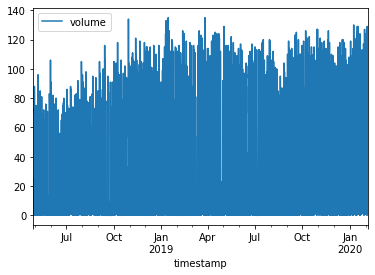

In [7]:
pd.plotting.register_matplotlib_converters()
df.plot()

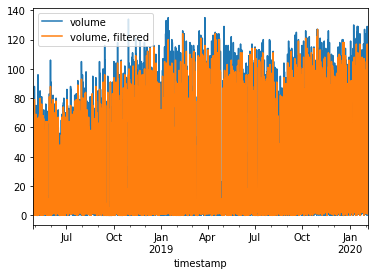

In [8]:
import utils
import scipy
from scipy.signal import medfilt
dfc = df.copy()
dfc.loc[:, 'volume, filtered'] = medfilt(dfc['volume'])
dfc.plot()


In [9]:
dfc.isnull().sum()

volume              0
volume, filtered    0
dtype: int64

In [10]:
df[df.isna().any(axis = 1)]

,volume
timestamp,


In [11]:
current_speed = dfc.loc[:,'volume, filtered'].rolling(window=50, center=True, min_periods=30).mean()
q25 = dfc.loc[:,'volume, filtered'].rolling(window=50, center=True, min_periods=30).quantile(0.25)
q75 = dfc.loc[:,'volume, filtered'].rolling(window=50, center=True, min_periods=30).quantile(0.75)

In [12]:
ndays_m = mdays.copy()
ndays_m[2] = 29

Text(0.5, 1.0, 'Volume')

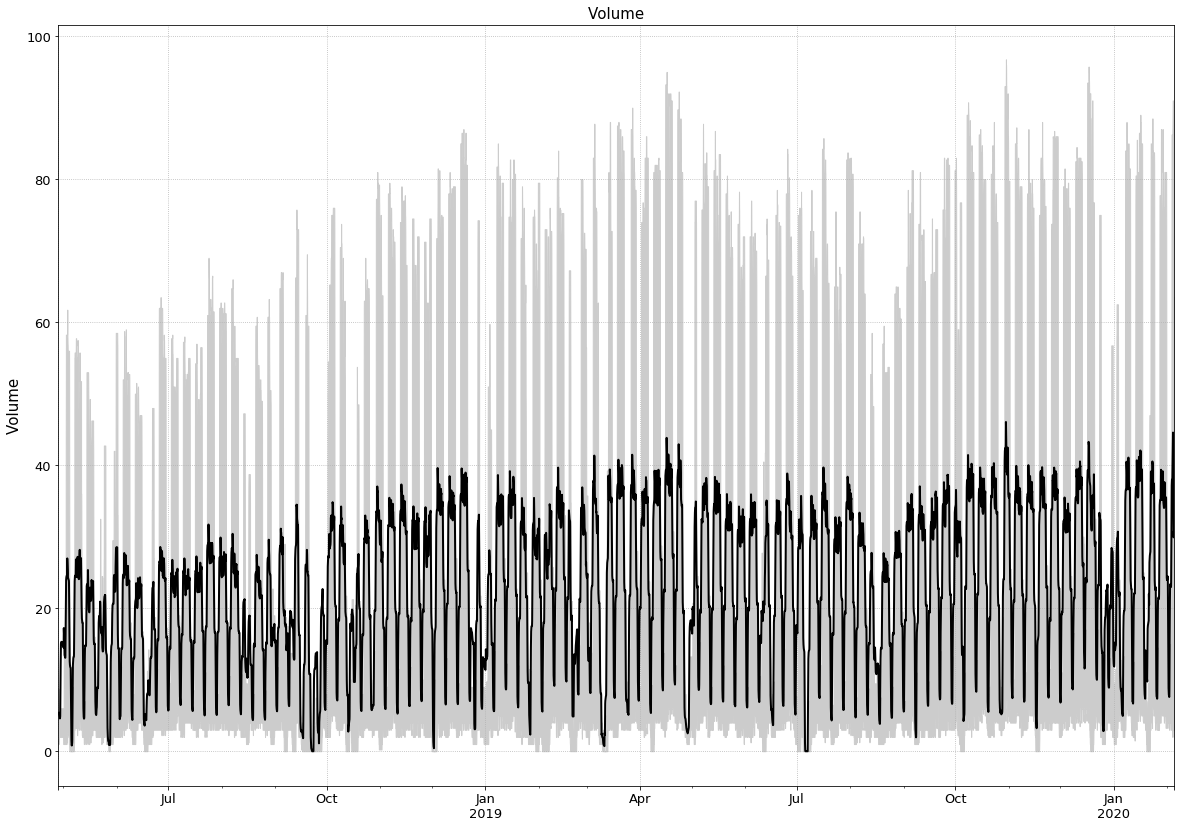

In [13]:
f, ax = plt.subplots(figsize=(20,14)) 

current_speed.plot(ax=ax, lw=2, color='k', legend=False)

ax.fill_between(current_speed.index, q25.values.ravel(), q75.values.ravel(), color='0.8')

#ax.set_xticks(ndays_m)
#ax.set_xticklabels(month_abbr)

ax.grid(ls=':')

ax.set_xlabel('', fontsize=15)

ax.set_ylabel('Volume', fontsize=15);

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_title('Volume', fontsize=15)

In [14]:
hour_week = dfc.loc[:, ['volume, filtered']].copy()
hour_week.loc[:, 'day_of_week'] = hour_week.index.dayofweek
hour_week.loc[:,'hour'] = hour_week.index.hour
hour_week = hour_week.groupby(['day_of_week', 'hour']).mean().unstack()
hour_week.columns = hour_week.columns.droplevel(0)

In [15]:
hour_week

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day_of_week,,,,,,,,,,,,,,,,,,,,,
0,1.795699,1.688172,1.387097,1.397849,1.763441,6.612903,23.752688,84.215054,87.698925,79.548387,...,63.258065,25.548387,17.376344,12.623656,9.290323,6.956989,6.440860,5.623656,3.290323,2.268817
1,1.763441,1.602151,1.301075,1.322581,1.666667,6.623656,20.967742,79.645161,84.688172,77.731183,...,59.333333,24.225806,16.494624,12.623656,9.236559,6.903226,6.408602,5.301075,3.365591,2.526882
2,1.826087,1.673913,1.250000,1.206522,1.695652,5.913043,21.206522,76.130435,79.728261,74.467391,...,54.728261,23.510870,15.858696,12.021739,8.739130,6.706522,6.260870,5.543478,3.467391,2.500000
3,1.945652,1.652174,1.434783,1.478261,2.000000,6.293478,21.097826,78.847826,80.619565,74.858696,...,60.673913,27.239130,18.586957,13.500000,10.304348,7.728261,7.369565,6.456522,4.141304,2.826087
4,2.217391,1.836957,1.565217,1.510870,1.891304,6.434783,22.641304,79.445652,83.195652,77.586957,...,64.956522,28.967391,21.358696,16.500000,12.771739,9.619565,8.500000,6.923913,4.195652,3.119565
5,2.559140,2.096774,1.537634,1.494624,1.806452,3.849462,10.645161,18.774194,19.935484,17.247312,...,10.806452,6.215054,4.838710,4.612903,3.784946,3.763441,4.397849,4.548387,3.774194,2.731183
6,2.365591,2.215054,1.677419,1.655914,1.881720,2.978495,5.548387,6.978495,7.505376,6.365591,...,6.344086,4.838710,4.010753,3.806452,3.430108,3.311828,4.161290,4.193548,3.376344,2.376344


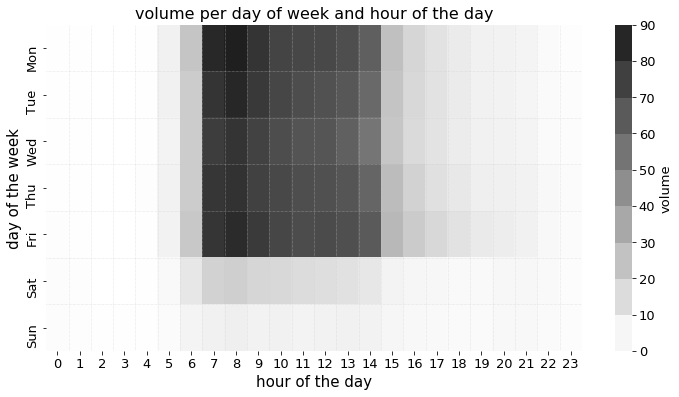

In [16]:
f, ax = plt.subplots(figsize=(12,6))

sns.heatmap(hour_week, ax = ax, cmap=plt.cm.gray_r, vmax=100, cbar_kws={'boundaries':np.arange(0,100,10)})
cbax = f.axes[1]
[l.set_fontsize(13) for l in cbax.yaxis.get_ticklabels()]
cbax.set_ylabel('volume', fontsize=13)

[ax.axhline(x, ls=':', lw=0.5, color='0.8') for x in np.arange(1, 7)]
[ax.axvline(x, ls=':', lw=0.5, color='0.8') for x in np.arange(1, 24)];

ax.set_title('volume per day of week and hour of the day', fontsize=16)

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_xlabel('hour of the day', fontsize=15)
ax.set_ylabel('day of the week', fontsize=15)
ax.set_yticklabels(day_abbr[0:7]);

In [17]:
weekdays = dfc.loc[dfc.index.strftime('%A').isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']), 'volume, filtered']
weekends = dfc.loc[dfc.index.strftime('%A').isin(['Saturda', 'Sunday']), 'volume, filtered']
summary_hour_weekdays = weekdays.groupby(weekdays.index.hour).describe()
summary_hour_weekends = weekends.groupby(weekends.index.hour).describe()

Text(0.5, 1.0, 'current volume per hour of the day')

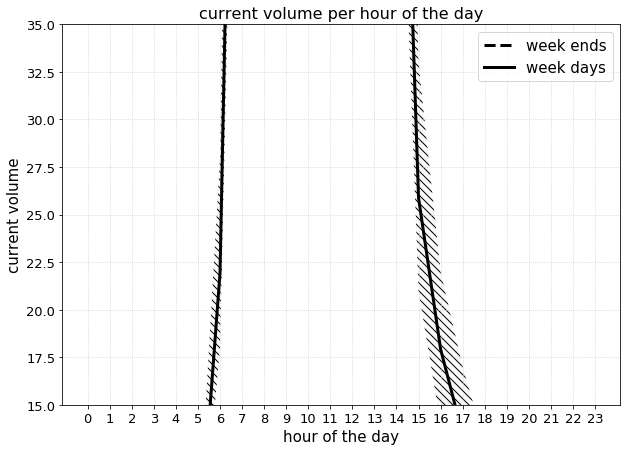

In [18]:
f, ax = plt.subplots(figsize = (10,7))
ax.plot(summary_hour_weekends.index, summary_hour_weekends.loc[:,'mean'], color='k', label='week ends', ls='--', lw=3)

ax.fill_between(summary_hour_weekends.index, summary_hour_weekends.loc[:,'25%'], \
                summary_hour_weekends.loc[:,'75%'], hatch='|||||', facecolor='0.8', alpha=0.1)

ax.set_xticks(range(24));

ax.grid(ls=':', color='0.8')

ax.plot(summary_hour_weekdays.index, summary_hour_weekdays.loc[:,'mean'], color='k', label='week days', lw=3)

ax.fill_between(summary_hour_weekdays.index, summary_hour_weekdays.loc[:,'25%'], \
                summary_hour_weekdays.loc[:,'75%'], hatch='\\\\\\', facecolor='0.8', alpha=0.1)

ax.legend(loc=1 , fontsize=15)

ax.set_xticks(range(24));

ax.grid(ls=':', color='0.8')

ax.set_ylim([15, 35])

ax.set_xlabel('hour of the day', fontsize=15)

ax.set_ylabel('current volume', fontsize=15);

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_title('current volume per hour of the day', fontsize=16)

In [19]:
data = dfc.loc[:, ['volume, filtered']].resample('60Min').mean()
data

,"volume, filtered"
timestamp,
2018-04-28 00:00:00,0.0
2018-04-28 01:00:00,0.0
2018-04-28 02:00:00,0.0
2018-04-28 03:00:00,0.0
2018-04-28 04:00:00,1.0
...,...
2020-02-04 19:00:00,4.0
2020-02-04 20:00:00,3.0
2020-02-04 21:00:00,3.0


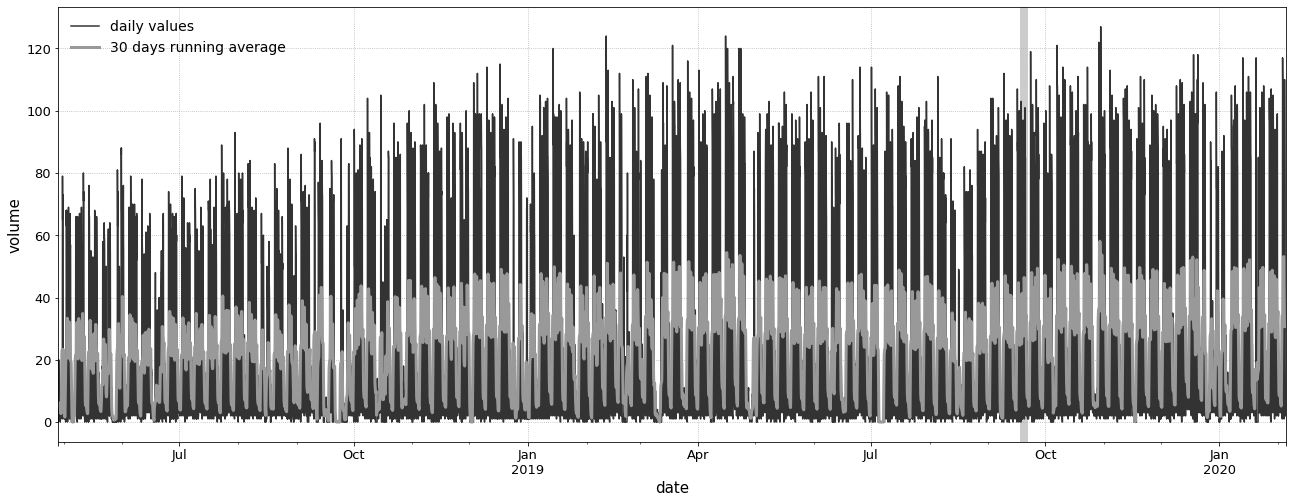

In [20]:
f, ax = plt.subplots(figsize=(22,8))
data.plot(ax=ax, color = '0.2')
data.rolling(window = 30, center = True).mean().plot(ax=ax, ls = '-', lw = 3, color = '0.6')
ax.grid(ls=':')
ax.legend(['daily values','30 days running average'], frameon=False, fontsize=14)
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_xlabel('date', fontsize=15)

ax.set_ylabel('volume', fontsize=15);

ax.axvline('20/09/2019', color='0.8', lw=8, zorder=-1)

In [21]:
data_train = data[data.index <'2019-09-20']
data_train = data_train.reset_index()
data_train = data_train.rename({'volume, filtered' : 'y', 'timestamp' : 'ds'}, axis = 1)
data_train

,ds,y
0,2018-04-28 00:00:00,0.0
1,2018-04-28 01:00:00,0.0
2,2018-04-28 02:00:00,0.0
3,2018-04-28 03:00:00,0.0
4,2018-04-28 04:00:00,1.0
...,...,...
12235,2019-09-19 19:00:00,15.0
12236,2019-09-19 20:00:00,14.0
12237,2019-09-19 21:00:00,10.0
12238,2019-09-19 22:00:00,8.0


In [22]:
data_test = data[data.index > '2019-09-20']
data_test = data_test.reset_index()
data_test = data_test.rename({'volume, filtered' : 'y', 'timestamp' : 'ds'}, axis = 1)
data_test

,ds,y
0,2019-09-20 01:00:00,1.0
1,2019-09-20 02:00:00,2.0
2,2019-09-20 03:00:00,2.0
3,2019-09-20 04:00:00,3.0
4,2019-09-20 05:00:00,8.0
...,...,...
3306,2020-02-04 19:00:00,4.0
3307,2020-02-04 20:00:00,3.0
3308,2020-02-04 21:00:00,3.0
3309,2020-02-04 22:00:00,3.0


In [23]:
m = Prophet(mcmc_samples=300, holidays=holidays_data, holidays_prior_scale=0.25, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', weekly_seasonality=True, daily_seasonality=True)

In [24]:
m.fit(data_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [25]:
future = m.make_future_dataframe(periods=len(data_test), freq='1H')

In [26]:
future.head()

,ds
0,2018-04-28 00:00:00
1,2018-04-28 01:00:00
2,2018-04-28 02:00:00
3,2018-04-28 03:00:00
4,2018-04-28 04:00:00


In [27]:
future.tail()

,ds
15546,2028-10-08 23:00:00
15547,2028-10-09 23:00:00
15548,2028-10-10 23:00:00
15549,2028-10-11 23:00:00
15550,2028-10-12 23:00:00


In [28]:
forecast = m.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Assumption,Assumption_lower,Assumption_upper,Boxing Day,...,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2018-04-28 00:00:00,16.255547,-21.320921,24.069441,15.748075,16.735624,0.0,0.0,0.0,0.0,...,-0.934811,-0.967631,-0.899998,-0.099123,-0.120349,-0.077908,0.0,0.0,0.0,1.059679
1,2018-04-28 01:00:00,16.256361,-21.000768,23.011726,15.749470,16.736388,0.0,0.0,0.0,0.0,...,-0.904771,-0.939406,-0.867370,-0.146548,-0.166936,-0.125668,0.0,0.0,0.0,1.548078
2,2018-04-28 02:00:00,16.257175,-22.932843,21.034129,15.750865,16.737029,0.0,0.0,0.0,0.0,...,-1.076082,-1.111735,-1.039756,-0.195561,-0.215936,-0.174962,0.0,0.0,0.0,-1.236884
3,2018-04-28 03:00:00,16.257989,-26.211135,16.015291,15.752259,16.737478,0.0,0.0,0.0,0.0,...,-1.343459,-1.380632,-1.309721,-0.245904,-0.265507,-0.225395,0.0,0.0,0.0,-5.583949
4,2018-04-28 04:00:00,16.258803,-27.961465,15.143039,15.753626,16.737927,0.0,0.0,0.0,0.0,...,-1.389667,-1.425813,-1.356891,-0.297298,-0.317000,-0.276632,0.0,0.0,0.0,-6.335527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15546,2028-10-08 23:00:00,-26.179669,-32.277258,33.181174,-237.184586,206.356226,0.0,0.0,0.0,0.0,...,-1.103501,-1.138967,-1.068533,-0.140257,-0.162663,-0.119562,0.0,0.0,0.0,2.709615
15547,2028-10-09 23:00:00,-26.194654,-115.005293,97.288672,-237.274316,206.475210,0.0,0.0,0.0,0.0,...,-0.527041,-0.556960,-0.495002,0.436203,0.413992,0.458219,0.0,0.0,0.0,-12.389003
15548,2028-10-10 23:00:00,-26.209638,-57.388074,51.277872,-237.364047,206.594194,0.0,0.0,0.0,0.0,...,-0.775269,-0.808563,-0.742182,0.187974,0.166788,0.210246,0.0,0.0,0.0,-5.890111
15549,2028-10-11 23:00:00,-26.224623,-76.243566,66.073883,-237.453777,206.713178,0.0,0.0,0.0,0.0,...,-0.694038,-0.726909,-0.660528,0.269206,0.248411,0.289343,0.0,0.0,0.0,-8.023750


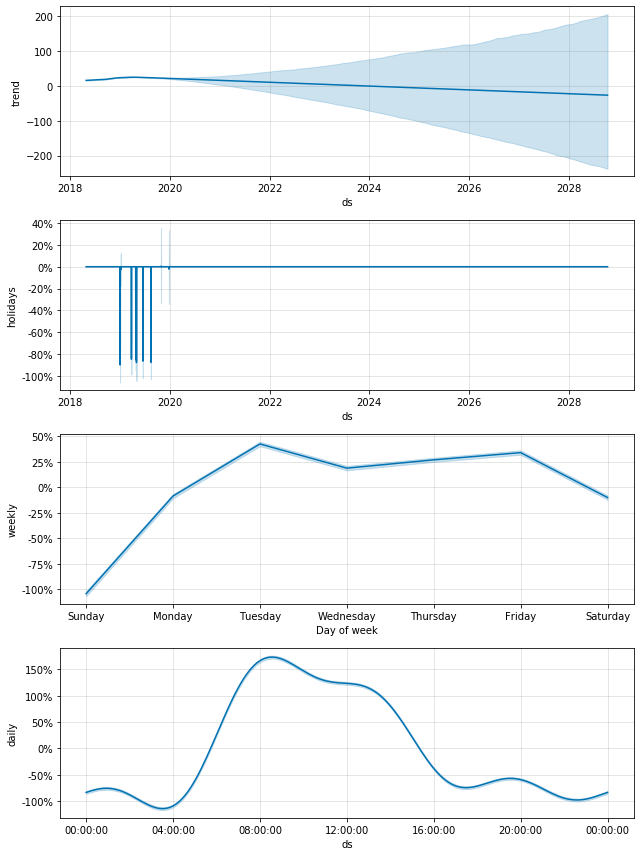

In [29]:
f = m.plot_components(forecast)

In [30]:
verif = utils.make_verif(forecast, data_train, data_test)

In [31]:
verif

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Assumption,Assumption_lower,Assumption_upper,Boxing Day,...,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,,
2018-04-28 00:00:00,2018-04-28 00:00:00,16.255547,-21.320921,24.069441,15.748075,16.735624,0.0,0.0,0.0,0.0,...,-0.967631,-0.899998,-0.099123,-0.120349,-0.077908,0.0,0.0,0.0,1.059679,0.0
2018-04-28 01:00:00,2018-04-28 01:00:00,16.256361,-21.000768,23.011726,15.749470,16.736388,0.0,0.0,0.0,0.0,...,-0.939406,-0.867370,-0.146548,-0.166936,-0.125668,0.0,0.0,0.0,1.548078,0.0
2018-04-28 02:00:00,2018-04-28 02:00:00,16.257175,-22.932843,21.034129,15.750865,16.737029,0.0,0.0,0.0,0.0,...,-1.111735,-1.039756,-0.195561,-0.215936,-0.174962,0.0,0.0,0.0,-1.236884,0.0
2018-04-28 03:00:00,2018-04-28 03:00:00,16.257989,-26.211135,16.015291,15.752259,16.737478,0.0,0.0,0.0,0.0,...,-1.380632,-1.309721,-0.245904,-0.265507,-0.225395,0.0,0.0,0.0,-5.583949,0.0
2018-04-28 04:00:00,2018-04-28 04:00:00,16.258803,-27.961465,15.143039,15.753626,16.737927,0.0,0.0,0.0,0.0,...,-1.425813,-1.356891,-0.297298,-0.317000,-0.276632,0.0,0.0,0.0,-6.335527,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2028-10-08 23:00:00,2028-10-08 23:00:00,-26.179669,-32.277258,33.181174,-237.184586,206.356226,0.0,0.0,0.0,0.0,...,-1.138967,-1.068533,-0.140257,-0.162663,-0.119562,0.0,0.0,0.0,2.709615,NaN
2028-10-09 23:00:00,2028-10-09 23:00:00,-26.194654,-115.005293,97.288672,-237.274316,206.475210,0.0,0.0,0.0,0.0,...,-0.556960,-0.495002,0.436203,0.413992,0.458219,0.0,0.0,0.0,-12.389003,NaN
2028-10-10 23:00:00,2028-10-10 23:00:00,-26.209638,-57.388074,51.277872,-237.364047,206.594194,0.0,0.0,0.0,0.0,...,-0.808563,-0.742182,0.187974,0.166788,0.210246,0.0,0.0,0.0,-5.890111,NaN


# Train Set

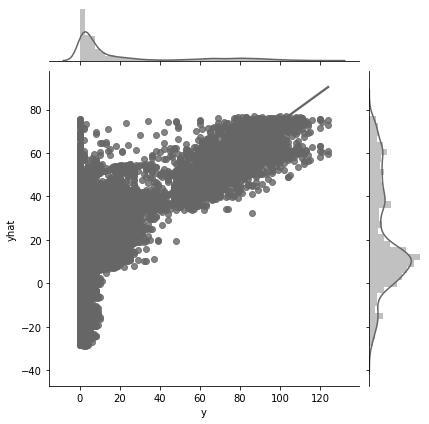

In [32]:
sns.jointplot('y', 'yhat',data = verif.loc[:'2019-09-20', :], kind = 'reg', color = '0.4')

In [33]:
verif = verif.dropna(subset = ['y'])
verif[pd.isnull(verif.y)]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Assumption,Assumption_lower,Assumption_upper,Boxing Day,...,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,,


In [34]:
verif.loc[:'2019-09-20', ['y', 'yhat']].corr()

,y,yhat
y,1.000000,0.820564
yhat,0.820564,1.000000


In [35]:
MAE(verif.loc[:'2019-09-20', 'y'].values, verif.loc[:'2019-09-20', 'yhat'].values)

12.984224286814841

# Test Set

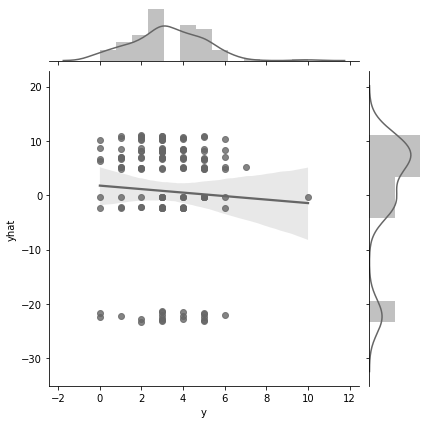

In [36]:
sns.jointplot('y', 'yhat',data = verif.loc['2019-09-20':, :], kind = 'reg', color = '0.4')


In [37]:
verif.loc['2019-09-20':, ['y', 'yhat']].corr()

,y,yhat
y,1.000000,-0.052064
yhat,-0.052064,1.000000


In [38]:
MAE(verif.loc['2019-09-20':, 'y'].values, verif.loc['2019-09-20':, 'yhat'].values)

7.75322094047049

Text(0, 0.5, 'NORMALIZED FREQUENCY')

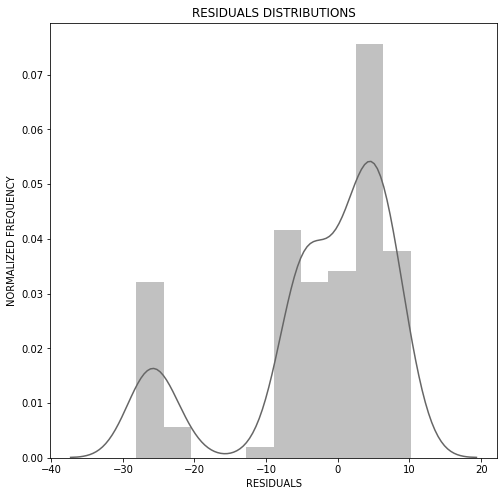

In [39]:
f, ax = plt.subplots(figsize = (8,8))
sns.distplot((verif.loc['2019-09-20':, 'yhat'] - verif.loc['2019-09-20': , 'y']), color = '0.4')
ax.set_title("RESIDUALS DISTRIBUTIONS")
ax.set_xlabel("RESIDUALS")
ax.set_ylabel("NORMALIZED FREQUENCY")

In [40]:
skew(verif.loc['2019-09-20':, 'y'].values - verif.loc['2019-09-20':, 'yhat'].values)

1.2717595255503709

In [41]:
residuals = (verif.loc['2019-09-20':, 'y']- verif.loc['2019-09-20':, 'yhat'])

In [42]:
residuals.median()

-1.0021990843094026

In [43]:
residuals.mean()

2.545273219191513

In [24]:
from VesselsData import aggregation_functionVessels
vessels_data = aggregation_functionVessels(60)

In [25]:
vessels_data

,vessel_count
Timestamp,
2018-04-27 00:00:00,5
2018-04-27 01:00:00,5
2018-04-27 02:00:00,5
2018-04-27 03:00:00,5
2018-04-27 04:00:00,5
...,...
2020-02-05 19:00:00,6
2020-02-05 20:00:00,6
2020-02-05 21:00:00,6


In [26]:
vessels_data = vessels_data.loc[:, ['vessel_count']]
vessels_data

,vessel_count
Timestamp,
2018-04-27 00:00:00,5
2018-04-27 01:00:00,5
2018-04-27 02:00:00,5
2018-04-27 03:00:00,5
2018-04-27 04:00:00,5
...,...
2020-02-05 19:00:00,6
2020-02-05 20:00:00,6
2020-02-05 21:00:00,6


In [27]:
vessels_data.corr()

,vessel_count
vessel_count,1.0


In [28]:
data_all = (data.reset_index()).merge(vessels_data, left_on = "timestamp", right_on = "Timestamp")
data_all.rename

data_all.set_index('timestamp', inplace = True)

In [29]:
data_all.corr()

,"volume, filtered",vessel_count
"volume, filtered",1.000000,0.117243
vessel_count,0.117243,1.000000


In [30]:
data_all['vessel_count'] = data_all['vessel_count'].interpolate(method = 'linear')

In [31]:
data_all

,"volume, filtered",vessel_count
timestamp,,
2018-04-28 00:00:00,0.0,3
2018-04-28 01:00:00,0.0,3
2018-04-28 02:00:00,0.0,3
2018-04-28 03:00:00,0.0,3
2018-04-28 04:00:00,1.0,3
...,...,...
2020-02-04 19:00:00,4.0,4
2020-02-04 20:00:00,3.0,5
2020-02-04 21:00:00,3.0,5


In [32]:
data_train_all = data_all[data_all.index < '2019-09-20']
data_train_all = data_train_all.reset_index()
data_train_all = data_train_all.rename({'volume, filtered' : 'y', 'timestamp' : 'ds'}, axis = 1)
data_train_all.tail()

,ds,y,vessel_count
12235,2019-09-19 19:00:00,15.0,4
12236,2019-09-19 20:00:00,14.0,4
12237,2019-09-19 21:00:00,10.0,5
12238,2019-09-19 22:00:00,8.0,5
12239,2019-09-19 23:00:00,4.0,4


In [33]:
data_test_all = data_all[data_all.index >= '2019-09-20']
data_test_all = data_test_all.reset_index()
data_test_all = data_test_all.rename({'volume, filtered' : 'y', 'timestamp' : 'ds'}, axis = 1)
data_test_all.tail()

,ds,y,vessel_count
3307,2020-02-04 19:00:00,4.0,4
3308,2020-02-04 20:00:00,3.0,5
3309,2020-02-04 21:00:00,3.0,5
3310,2020-02-04 22:00:00,3.0,5
3311,2020-02-04 23:00:00,2.0,6


In [34]:
m = Prophet(mcmc_samples=300, holidays=holidays_data, holidays_prior_scale=0.25, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', weekly_seasonality=True, daily_seasonality=True)

In [35]:
m.add_regressor('vessel_count', prior_scale = 0.5, mode = 'additive')

In [36]:
m.fit(data_train_all)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [37]:
future = m.make_future_dataframe(periods = len(data_test_all), freq = '1H')

In [38]:
future.head()

,ds
0,2018-04-28 00:00:00
1,2018-04-28 01:00:00
2,2018-04-28 02:00:00
3,2018-04-28 03:00:00
4,2018-04-28 04:00:00


In [39]:
future.tail()

,ds
15547,2020-02-04 19:00:00
15548,2020-02-04 20:00:00
15549,2020-02-04 21:00:00
15550,2020-02-04 22:00:00
15551,2020-02-04 23:00:00


In [40]:
futures = (future).merge(data_all[['vessel_count']], left_on = "ds", right_on = "timestamp")

In [41]:
forecast = m.predict(futures)

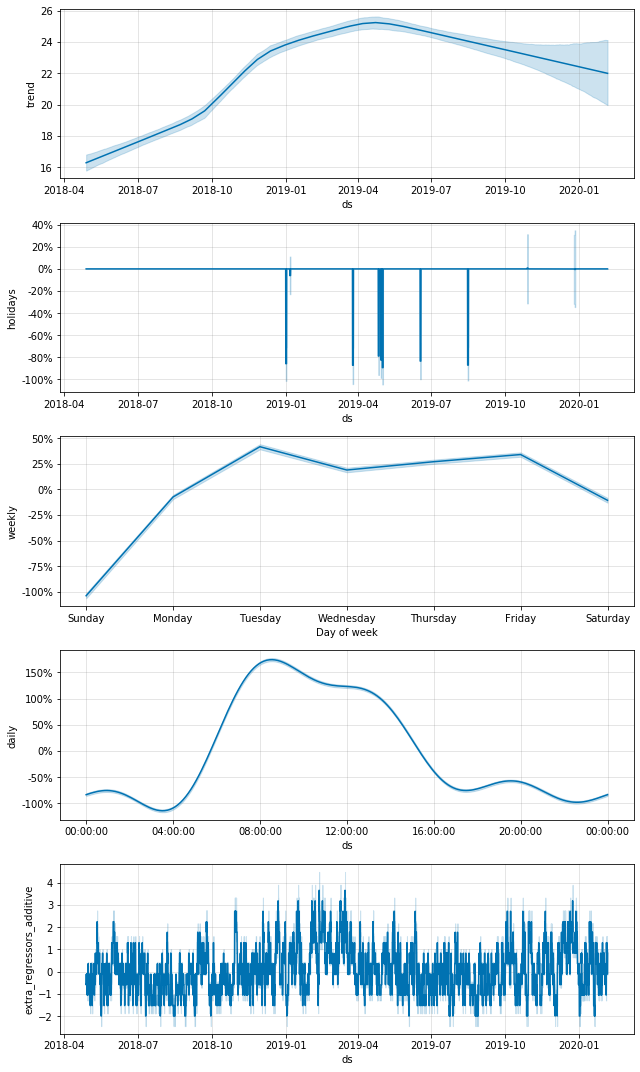

In [42]:
f = m.plot_components(forecast)

In [43]:
verif = utils.make_verif(forecast, data_train_all, data_test_all)

In [44]:
verif.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Assumption,Assumption_lower,Assumption_upper,Boxing Day,...,multiplicative_terms_lower,multiplicative_terms_upper,vessel_count,vessel_count_lower,vessel_count_upper,weekly,weekly_lower,weekly_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,,
2018-04-28 00:00:00,2018-04-28 00:00:00,16.280906,-21.661837,21.689142,15.775761,16.803735,0.0,0.0,0.0,0.0,...,-0.978173,-0.906068,-0.585062,-0.717477,-0.451472,-0.106511,-0.129741,-0.082253,0.378917,0.0
2018-04-28 01:00:00,2018-04-28 01:00:00,16.281767,-20.528597,22.127390,15.776839,16.804356,0.0,0.0,0.0,0.0,...,-0.948440,-0.870623,-0.585062,-0.717477,-0.451472,-0.154291,-0.177110,-0.130679,0.886547,0.0
2018-04-28 02:00:00,2018-04-28 02:00:00,16.282628,-24.346150,19.277459,15.777917,16.804977,0.0,0.0,0.0,0.0,...,-1.116777,-1.045016,-0.585062,-0.717477,-0.451472,-0.203614,-0.226690,-0.180754,-1.898065,0.0
2018-04-28 03:00:00,2018-04-28 03:00:00,16.283489,-27.108071,15.852711,15.778995,16.805598,0.0,0.0,0.0,0.0,...,-1.384842,-1.311794,-0.585062,-0.717477,-0.451472,-0.254218,-0.277286,-0.231628,-6.265656,0.0
2018-04-28 04:00:00,2018-04-28 04:00:00,16.284350,-30.230898,15.149783,15.780073,16.806219,0.0,0.0,0.0,0.0,...,-1.433776,-1.355137,-0.585062,-0.717477,-0.451472,-0.305819,-0.328472,-0.283417,-7.025236,1.0


# Train Set

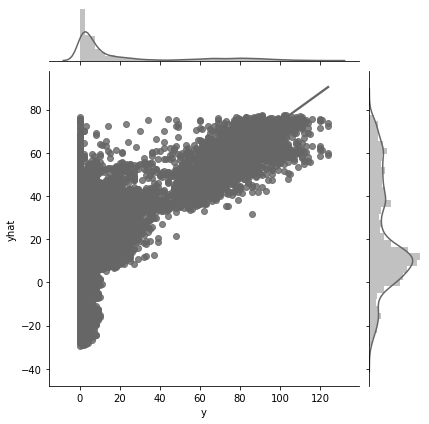

In [45]:
sns.jointplot('y', 'yhat', data = verif.loc[:'2019-09-20', :], kind = 'reg', color = '0.4')

In [46]:
verif = verif.dropna(subset = ['y'])
verif[pd.isnull(verif.y)]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Assumption,Assumption_lower,Assumption_upper,Boxing Day,...,multiplicative_terms_lower,multiplicative_terms_upper,vessel_count,vessel_count_lower,vessel_count_upper,weekly,weekly_lower,weekly_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,,


In [47]:
verif.loc[:'2019-09-20', ['y', 'yhat']].corr()

,y,yhat
y,1.000000,0.821335
yhat,0.821335,1.000000


In [48]:
MAE(verif.loc[:'2019-09-20', 'y'].values, verif.loc[:'2019-09-20', 'yhat'].values)

12.973426854124352

In [49]:
MAE(verif.loc[:'2019-09-20', 'y'].values, verif.loc[:'2019-09-20', 'yhat'].values)

12.973426854124352

# Test Set

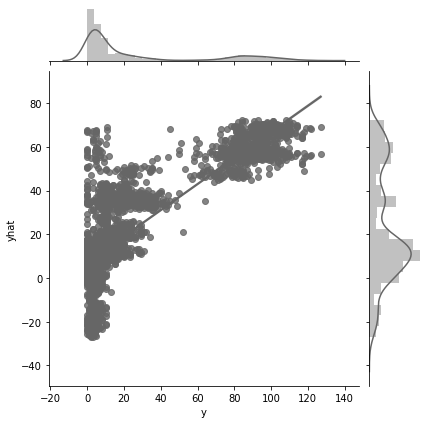

In [50]:
sns.jointplot('y', 'yhat',data = verif.loc['2019-09-20':, :], kind = 'reg', color = '0.4')

In [51]:
verif.loc['2019-09-20':, ['y', 'yhat']].corr()

,y,yhat
y,1.00000,0.83294
yhat,0.83294,1.00000


In [52]:
MAE(verif.loc['2019-09-20':, 'y'].values, verif.loc['2019-09-20':, 'yhat'].values)

15.052697113473565

Text(0, 0.5, 'NORMALIZED FREQUENCY')

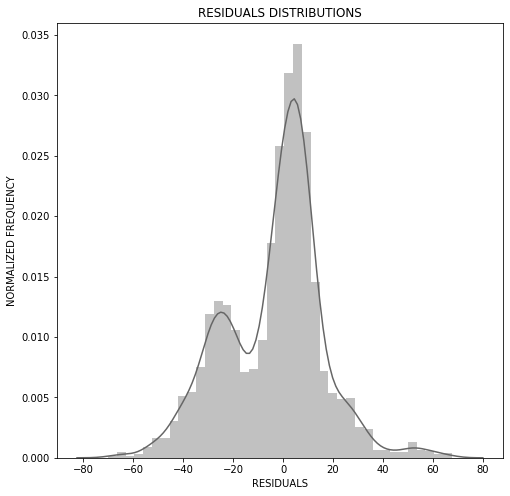

In [53]:
f, ax = plt.subplots(figsize = (8,8))
sns.distplot((verif.loc['2019-09-20':, 'yhat'] - verif.loc['2019-09-20': , 'y']), color = '0.4')
ax.set_title("RESIDUALS DISTRIBUTIONS")
ax.set_xlabel("RESIDUALS")
ax.set_ylabel("NORMALIZED FREQUENCY")

In [54]:
skew(verif.loc['2019-09-20':, 'y'].values - verif.loc['2019-09-20':, 'yhat'].values)

0.1272811702668933

In [55]:
residuals = (verif.loc['2019-09-20':, 'y']- verif.loc['2019-09-20':, 'yhat'])

In [56]:
residuals.median()

-0.3865456521794792

In [57]:
residuals.mean()

3.5490639679902736

In [58]:
verif

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Assumption,Assumption_lower,Assumption_upper,Boxing Day,...,multiplicative_terms_lower,multiplicative_terms_upper,vessel_count,vessel_count_lower,vessel_count_upper,weekly,weekly_lower,weekly_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,,
2018-04-28 00:00:00,2018-04-28 00:00:00,16.280906,-21.661837,21.689142,15.775761,16.803735,0.0,0.0,0.0,0.0,...,-0.978173,-0.906068,-0.585062,-0.717477,-0.451472,-0.106511,-0.129741,-0.082253,0.378917,0.0
2018-04-28 01:00:00,2018-04-28 01:00:00,16.281767,-20.528597,22.127390,15.776839,16.804356,0.0,0.0,0.0,0.0,...,-0.948440,-0.870623,-0.585062,-0.717477,-0.451472,-0.154291,-0.177110,-0.130679,0.886547,0.0
2018-04-28 02:00:00,2018-04-28 02:00:00,16.282628,-24.346150,19.277459,15.777917,16.804977,0.0,0.0,0.0,0.0,...,-1.116777,-1.045016,-0.585062,-0.717477,-0.451472,-0.203614,-0.226690,-0.180754,-1.898065,0.0
2018-04-28 03:00:00,2018-04-28 03:00:00,16.283489,-27.108071,15.852711,15.778995,16.805598,0.0,0.0,0.0,0.0,...,-1.384842,-1.311794,-0.585062,-0.717477,-0.451472,-0.254218,-0.277286,-0.231628,-6.265656,0.0
2018-04-28 04:00:00,2018-04-28 04:00:00,16.284350,-30.230898,15.149783,15.780073,16.806219,0.0,0.0,0.0,0.0,...,-1.433776,-1.355137,-0.585062,-0.717477,-0.451472,-0.305819,-0.328472,-0.283417,-7.025236,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-04 19:00:00,2020-02-04 19:00:00,22.000533,-9.077221,35.529436,19.971563,24.127910,0.0,0.0,0.0,0.0,...,-0.439659,-0.371831,-0.114150,-0.139985,-0.088086,0.194317,0.172929,0.215638,12.987358,4.0
2020-02-04 20:00:00,2020-02-04 20:00:00,22.000039,-6.681099,35.792719,19.969894,24.128072,0.0,0.0,0.0,0.0,...,-0.435990,-0.365555,0.356762,0.275301,0.437507,0.191249,0.169803,0.213387,13.539193,3.0
2020-02-04 21:00:00,2020-02-04 21:00:00,21.999545,-12.108583,31.625378,19.968225,24.128234,0.0,0.0,0.0,0.0,...,-0.607431,-0.531838,0.356762,0.275301,0.437507,0.189345,0.167476,0.211777,9.793436,3.0


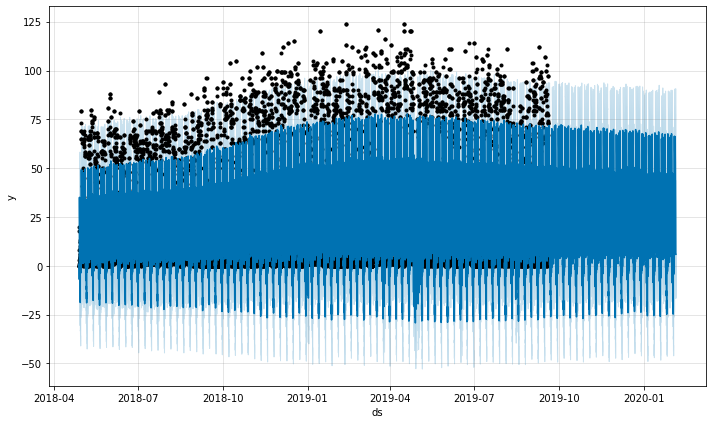

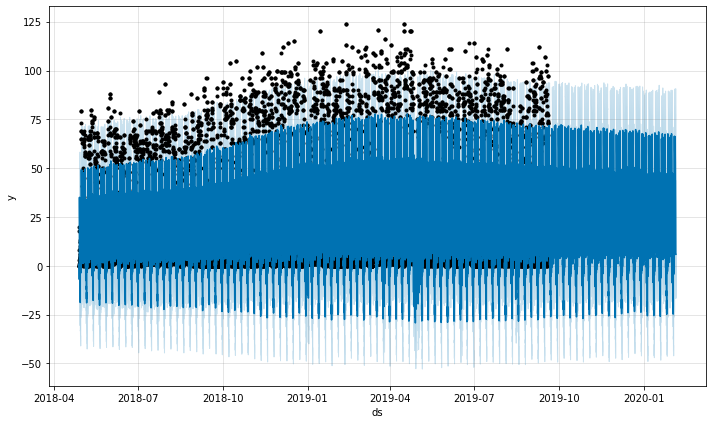

In [59]:
m.plot(forecast)

Text(0, 0.5, 'Volume')

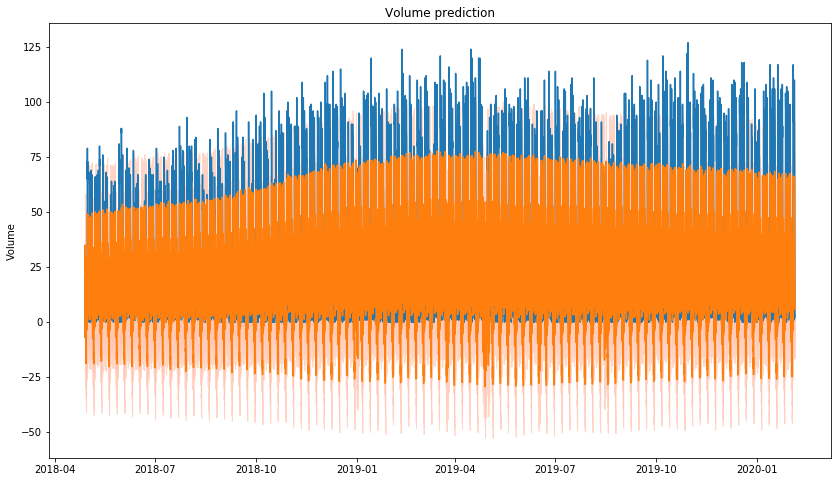

In [60]:
fig, ax = plt.subplots(figsize = (14,8))
ax.plot(verif.index, verif['y'], label = 'True values')
ax.plot(verif.index, verif['yhat'], label = 'Predicted values')
ax.set_title("Volume prediction")
ax.fill_between(verif.index, verif.loc[:, 'yhat_lower'], verif.loc[:, 'yhat_upper'], color = 'coral', alpha = 0.3)
plt.ylabel("Volume")

# Correlaciones diarias

In [61]:
corr = verif.loc[:, ['y', 'yhat']].rolling(window = 1000).corr()

In [62]:
corr.index = corr.index.droplevel(1)

Text(0.5, 1.0, 'Correlaciones con media rodante de 1000 períodos')

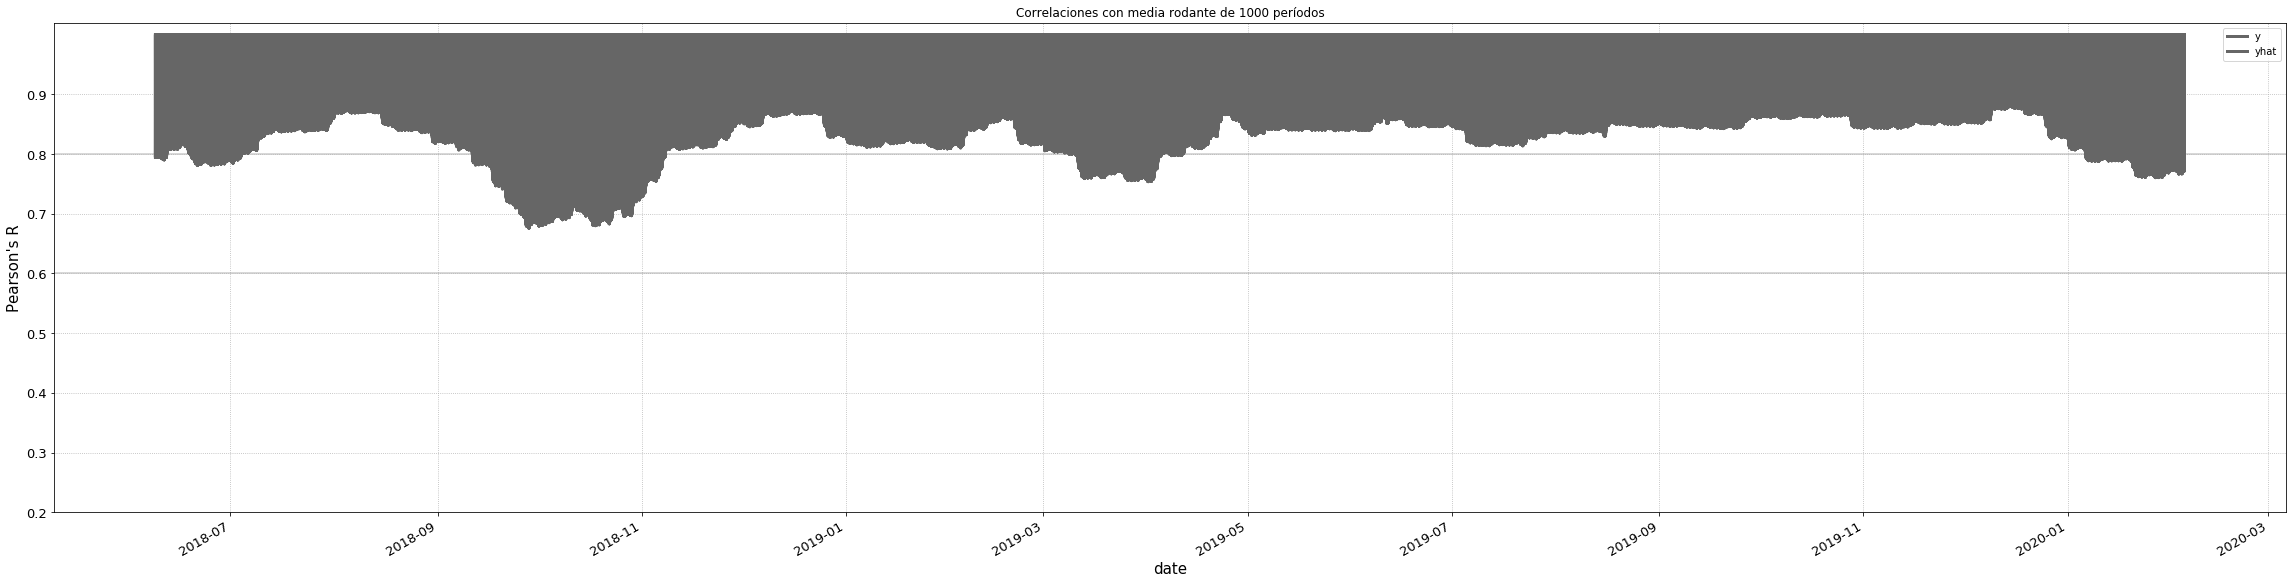

In [63]:
fig, ax = plt.subplots(figsize = (40,10))
corr.plot(ax=ax, lw = 3, color = '0.4')
ax.axhline(0.8, color='0.8', zorder=-1)
ax.axhline(0.6, color='0.8', zorder=-1)
ax.grid(ls=':')
ax.set_xlabel('date', fontsize=15)
ax.set_ylabel("Pearson's R", fontsize=15)
ax.grid(ls=':')
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_yticks(np.arange(0.2, 1., 0.1)); 
ax.set_title('Correlaciones con media rodante de 1000 períodos')


Mucha variabilidad en los datos a lo largo del día, con mucho porcentaje aleatorio que Prophet no es capaz de predecir. 

# Correlaciones por mes

In [64]:
corr_season_train = verif.loc[:'2019-09-20', ['y', 'yhat']].groupby(verif.loc[:'2019-09-20', :].index.month).corr()
corr_season_test = verif.loc['2019-09-20':, ['y', 'yhat']].groupby(verif.loc['2019-09-20':, :].index.month).corr()
corr_season = verif.loc[:,['y','yhat']].groupby(verif.loc[:,:].index.month).corr()

Text(0.5, 1.0, 'Correlation per month')

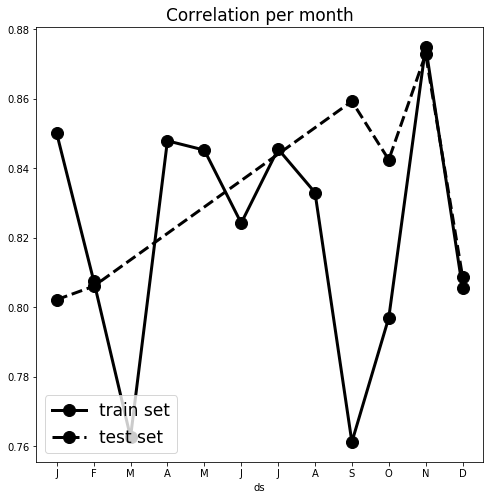

In [65]:
f, ax = plt.subplots(figsize=(8,8))
corr_season_train.xs('y', axis=0, level=1)['yhat'].plot(ax=ax, lw=3, marker='o', markersize=12, label='train set', ls='-', color='k')
corr_season_test.xs('y', axis=0, level=1)['yhat'].plot(ax=ax, lw=3, marker='o', markersize=12, label='test set', ls='--', color='k')
# corr_season.xs('y', axis=0, level=1)['yhat'].plot(ax=ax, lw=3, marker='o', markersize=12)

ax.legend(fontsize=17, loc=3)

ax.set_xticks(range(1, 13))
ax.set_xticklabels(list('JFMAMJJASOND'))
ax.set_title('Correlation per month', fontsize=17)